In [2]:
"""
Absolute vs Relative Time Index Demo

This notebook demonstrates the AbsoluteRelativeIndex, which handles trial-based 
data where each trial has both absolute time (experiment time) and relative time
(time within the trial).
"""
import matplotlib.pyplot as plt

from linked_indices import AbsoluteRelativeIndex
from linked_indices.example_data import trial_based_dataset

In [3]:
# Generate example trial-based data
# 5 trials, each 10 seconds long, sampled at 100 Hz
ds = trial_based_dataset(n_trials=5, trial_length=10.0, sample_rate=100)
ds

<xarray.Dataset> Size: 88kB
Dimensions:      (trial: 5, rel_time: 1000)
Coordinates:
  * trial        (trial) <U7 140B 'trial_0' 'trial_1' ... 'trial_3' 'trial_4'
  * rel_time     (rel_time) float64 8kB 0.0 0.01 0.02 0.03 ... 9.97 9.98 9.99
    abs_time     (trial, rel_time) float64 40kB 0.0 0.01 0.02 ... 49.98 49.99
    trial_onset  (trial) float64 40B 0.0 10.0 20.0 30.0 40.0
Data variables:
    data         (trial, rel_time) float64 40kB 0.04967 0.04896 ... 0.1026


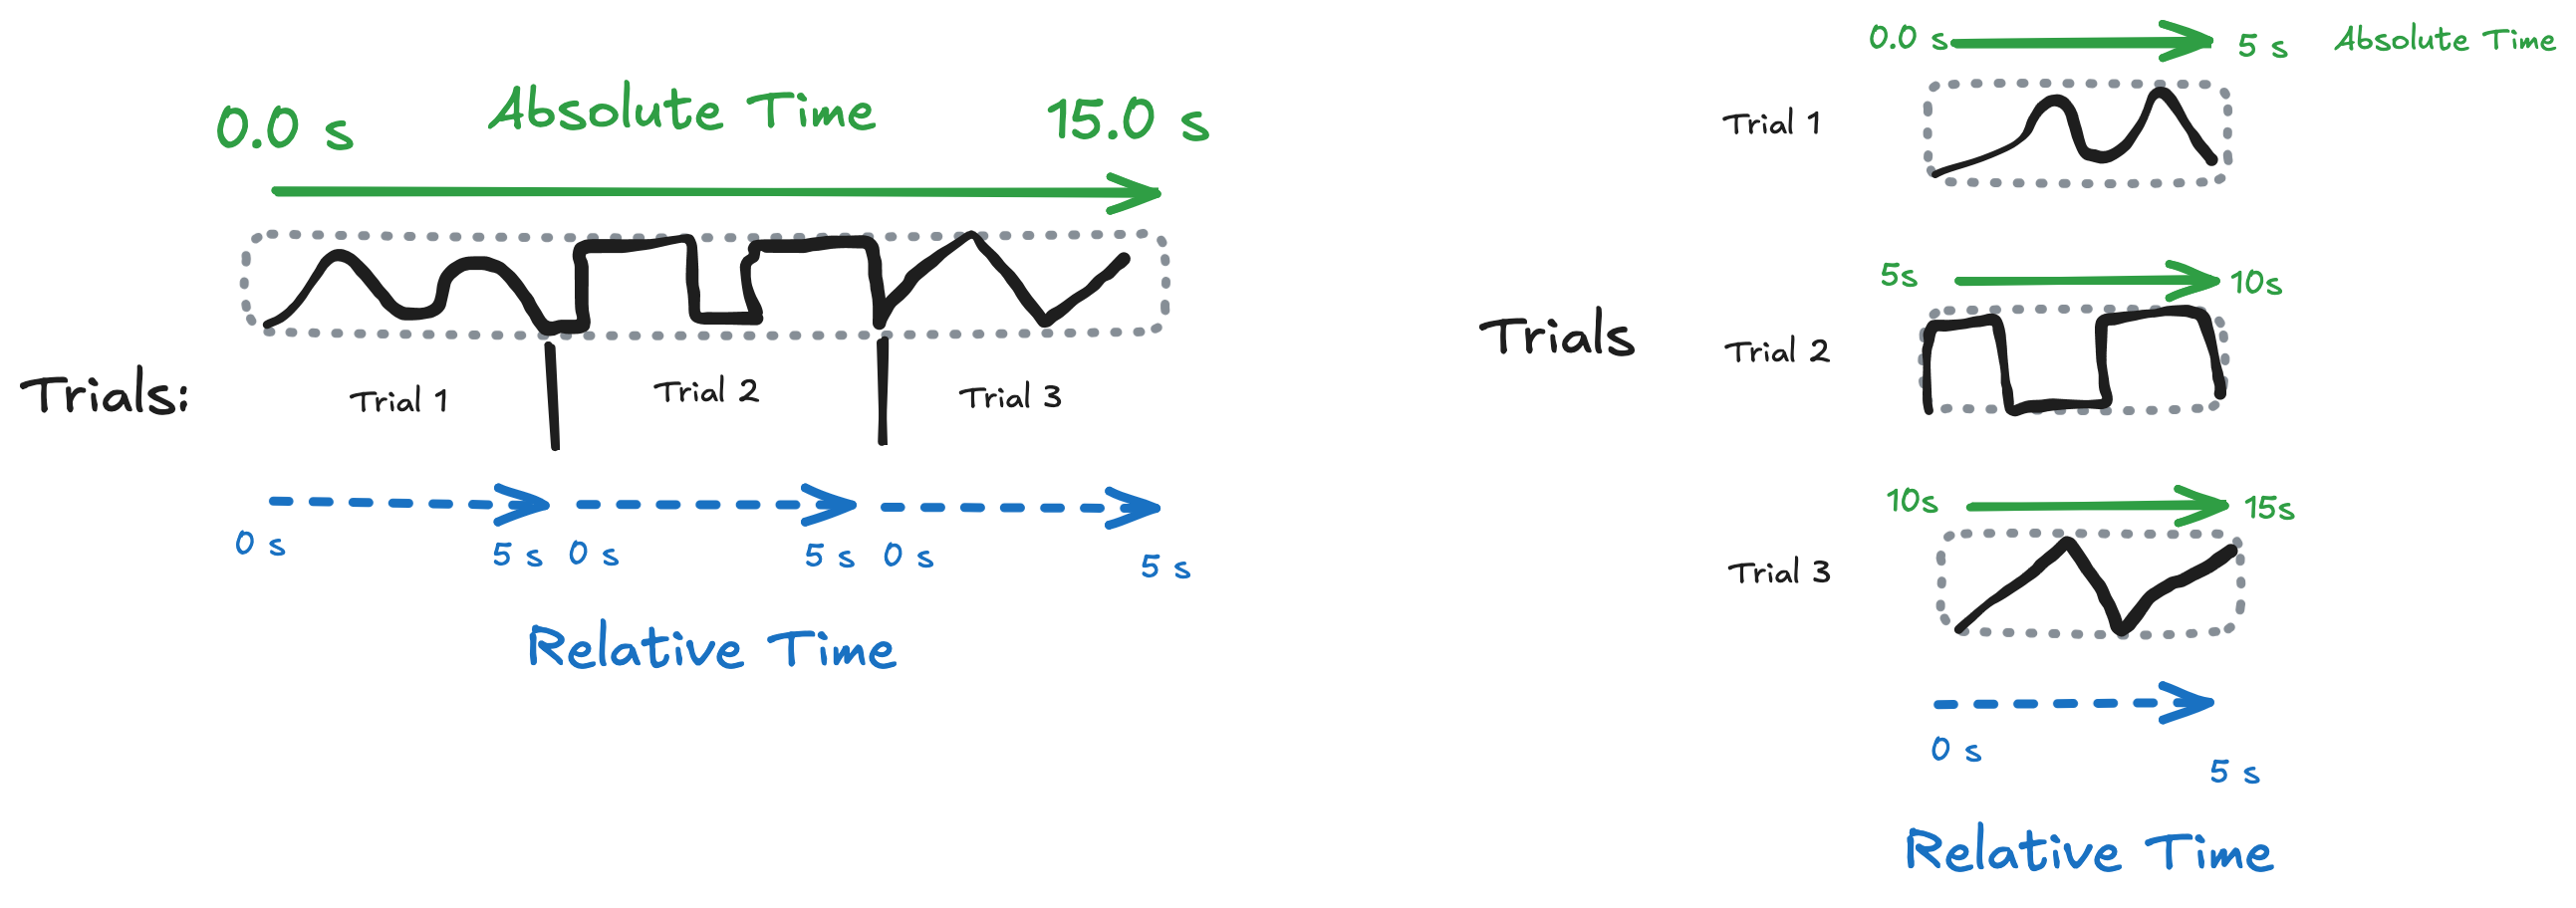

In [12]:
# The abs_time coordinate is 2D: maps (trial, rel_time) -> absolute time
ds.abs_time

<xarray.DataArray 'abs_time' (trial: 5, rel_time: 1000)> Size: 40kB
array([[0.000e+00, 1.000e-02, 2.000e-02, ..., 9.970e+00, 9.980e+00,
        9.990e+00],
       [1.000e+01, 1.001e+01, 1.002e+01, ..., 1.997e+01, 1.998e+01,
        1.999e+01],
       [2.000e+01, 2.001e+01, 2.002e+01, ..., 2.997e+01, 2.998e+01,
        2.999e+01],
       [3.000e+01, 3.001e+01, 3.002e+01, ..., 3.997e+01, 3.998e+01,
        3.999e+01],
       [4.000e+01, 4.001e+01, 4.002e+01, ..., 4.997e+01, 4.998e+01,
        4.999e+01]], shape=(5, 1000))
Coordinates:
  * trial        (trial) <U7 140B 'trial_0' 'trial_1' ... 'trial_3' 'trial_4'
  * rel_time     (rel_time) float64 8kB 0.0 0.01 0.02 0.03 ... 9.97 9.98 9.99
    abs_time     (trial, rel_time) float64 40kB 0.0 0.01 0.02 ... 49.98 49.99
    trial_onset  (trial) float64 40B 0.0 10.0 20.0 30.0 40.0

In [6]:
# Apply the AbsoluteRelativeIndex
# First drop the default indexes, then set our custom index
ds_indexed = ds.drop_indexes(["trial", "rel_time"]).set_xindex(
    ["abs_time", "trial", "rel_time"],
    AbsoluteRelativeIndex,
)
ds_indexed

<xarray.Dataset> Size: 88kB
Dimensions:      (trial: 5, rel_time: 1000)
Coordinates:
  * trial        (trial) <U7 140B 'trial_0' 'trial_1' ... 'trial_3' 'trial_4'
  * rel_time     (rel_time) float64 8kB 0.0 0.01 0.02 0.03 ... 9.97 9.98 9.99
    trial_onset  (trial) float64 40B 0.0 10.0 20.0 30.0 40.0
  * abs_time     (trial, rel_time) float64 40kB 0.0 0.01 0.02 ... 49.98 49.99
Data variables:
    data         (trial, rel_time) float64 40kB 0.04967 0.04896 ... 0.1026
Indexes:
  ┌ abs_time  AbsoluteRelativeIndex
  │ trial
  └ rel_time

In [13]:
# Select by absolute time - finds the correct (trial, rel_time) point
# abs_time=25 is in trial_2 (which spans 20-30s), at rel_time=5
result = ds_indexed.sel(abs_time=25.0, method="nearest")
result

<xarray.Dataset> Size: 60B
Dimensions:      (trial: 1, rel_time: 1)
Coordinates:
  * trial        (trial) <U7 28B 'trial_2'
  * rel_time     (rel_time) float64 8B 5.0
    trial_onset  (trial) float64 8B 20.0
  * abs_time     (trial, rel_time) float64 8B 25.0
Data variables:
    data         (trial, rel_time) float64 8B 1.057
Indexes:
  ┌ abs_time  AbsoluteRelativeIndex
  │ trial
  └ rel_time

In [8]:
# Select a range of absolute time that spans multiple trials
# abs_time 15-25 spans trial_1 (10-20) and trial_2 (20-30)
result_range = ds_indexed.sel(abs_time=slice(15.0, 25.0))
print(f"Trials selected: {list(result_range.trial.values)}")
print(f"Number of rel_time points: {result_range.sizes['rel_time']}")
result_range

Trials selected: [np.str_('trial_1'), np.str_('trial_2')]
Number of rel_time points: 1000


<xarray.Dataset> Size: 40kB
Dimensions:      (trial: 2, rel_time: 1000)
Coordinates:
  * trial        (trial) <U7 56B 'trial_1' 'trial_2'
  * rel_time     (rel_time) float64 8kB 0.0 0.01 0.02 0.03 ... 9.97 9.98 9.99
    trial_onset  (trial) float64 16B 10.0 20.0
  * abs_time     (trial, rel_time) float64 16kB 10.0 10.01 10.02 ... 29.98 29.99
Data variables:
    data         (trial, rel_time) float64 16kB 0.847 0.863 ... 1.002 0.9766
Indexes:
  ┌ abs_time  AbsoluteRelativeIndex
  │ trial
  └ rel_time

In [9]:
# Select by trial - get all data for a specific trial
trial_data = ds_indexed.sel(trial="trial_2")
print(
    f"Trial 2 abs_time range: {float(trial_data.abs_time.min()):.1f} - {float(trial_data.abs_time.max()):.1f}"
)
trial_data

Trial 2 abs_time range: 20.0 - 30.0


<xarray.Dataset> Size: 24kB
Dimensions:      (rel_time: 1000, trial: 1)
Coordinates:
  * rel_time     (rel_time) float64 8kB 0.0 0.01 0.02 0.03 ... 9.97 9.98 9.99
  * trial        (trial) <U7 28B 'trial_2'
    trial_onset  float64 8B 20.0
  * abs_time     (trial, rel_time) float64 8kB 20.0 20.01 20.02 ... 29.98 29.99
Data variables:
    data         (rel_time) float64 8kB 0.9325 0.9777 0.8893 ... 1.002 0.9766
Indexes:
  ┌ abs_time  AbsoluteRelativeIndex
  │ trial
  └ rel_time

In [10]:
# Select by relative time - same relative time across all trials
# This is useful for comparing the same timepoint within each trial
rel_time_data = ds_indexed.sel(rel_time=5.0, method="nearest")
print(f"Selected rel_time: {float(rel_time_data.rel_time):.2f}")
print(f"abs_time values at this rel_time: {rel_time_data.abs_time.values}")
rel_time_data

Selected rel_time: 5.00
abs_time values at this rel_time: [ 5. 15. 25. 35. 45.]


<xarray.Dataset> Size: 268B
Dimensions:      (trial: 5)
Coordinates:
    trial        (trial) <U7 140B 'trial_0' 'trial_1' ... 'trial_3' 'trial_4'
    trial_onset  (trial) float64 40B 0.0 10.0 20.0 30.0 40.0
    abs_time     (trial) float64 40B 5.0 15.0 25.0 35.0 45.0
    rel_time     float64 8B 5.0
Data variables:
    data         (trial) float64 40B 0.09262 -0.6293 1.057 -0.589 -0.09588

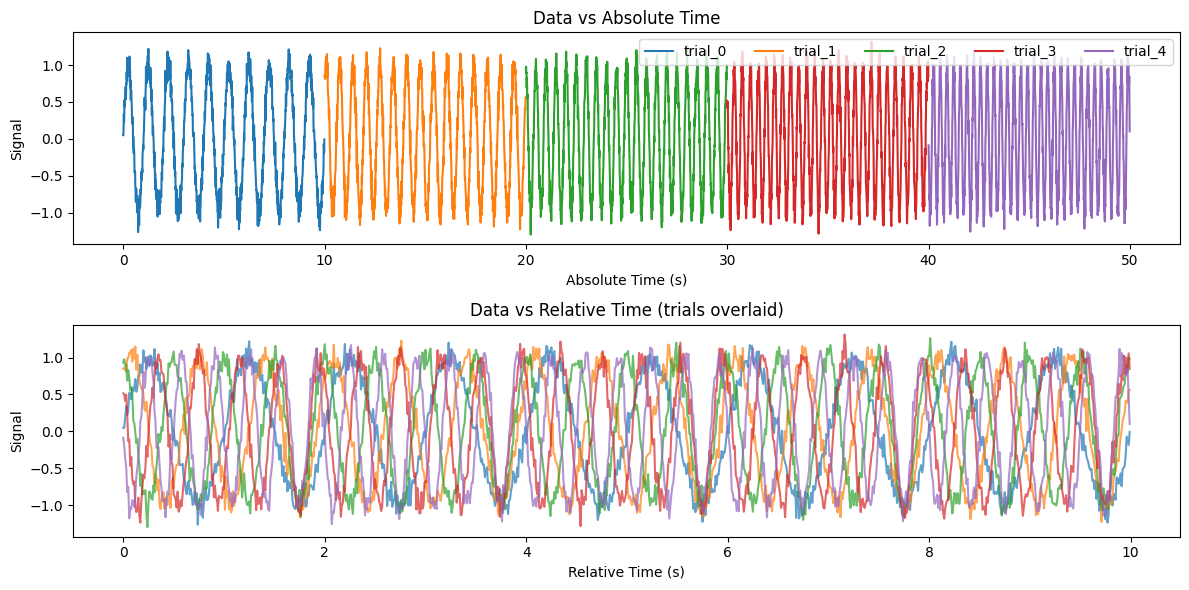

In [11]:
# Visualize the data
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Plot as 1D with absolute time
for i, trial in enumerate(ds_indexed.trial.values):
    trial_slice = ds_indexed.sel(trial=trial)
    # Flatten the abs_time since it's still 2D after selection
    abs_time_flat = trial_slice.abs_time.values.flatten()
    data_flat = trial_slice.data.values.flatten()
    axes[0].plot(abs_time_flat, data_flat, label=trial)
axes[0].set_xlabel("Absolute Time (s)")
axes[0].set_ylabel("Signal")
axes[0].set_title("Data vs Absolute Time")
axes[0].legend(loc="upper right", ncol=5)

# Plot as 2D with relative time (all trials overlaid)
for i, trial in enumerate(ds_indexed.trial.values):
    trial_slice = ds_indexed.sel(trial=trial)
    rel_time_flat = trial_slice.rel_time.values.flatten()
    data_flat = trial_slice.data.values.flatten()
    axes[1].plot(rel_time_flat, data_flat, alpha=0.7, label=trial)
axes[1].set_xlabel("Relative Time (s)")
axes[1].set_ylabel("Signal")
axes[1].set_title("Data vs Relative Time (trials overlaid)")

plt.tight_layout()